## First, implement similarity metrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.metrics
import os

In [3]:
#Paramaters
memory_method = 'random'

#create directory to save images for this memory method. 

base_directory = 'similarity_metric_plots'
directory_path = os.path.join(base_directory, memory_method)
# Check if the directory exists, and create it if it doesn't
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' was created.")
else:
    print(f"Directory '{directory_path}' already exists.")


Directory 'similarity_metric_plots/random' already exists.


In [27]:
import scipy

In [36]:
# converting to square

def flat_to_square(actual, ideal):
    sqrt_size = int(actual.shape[1] ** 0.5)
    first_layer_size = actual.shape[0]

    actual_structural = actual.reshape(first_layer_size, sqrt_size, sqrt_size)
    ideal_structural = ideal.reshape(first_layer_size, sqrt_size, sqrt_size)
    return actual_structural, ideal_structural

# MSE
def mse(actual, ideal):
    return np.mean((actual.flatten() - ideal.flatten()) ** 2)

# Cosine Similarity
def cos_sim(actual, ideal):
    actual_flat, ideal_flat = actual.flatten(), ideal.flatten()
    dot = np.dot(actual_flat, ideal_flat)
    return dot / (np.linalg.norm(actual_flat) * np.linalg.norm(ideal_flat)) 


# peak signal to noise ratio
def psnr(actual, ideal):
    print('dont use psnr')
    assert False
    return skimage.metrics.peak_signal_noise_ratio(actual, ideal)

# Structural Similarity Index (SSIM)
# need to specify data_range for this method
def ssim(actual_structural, ideal_structural): 
    combined = np.concatenate((actual_structural.flatten(), ideal_structural.flatten()))
    data_range = np.max(combined) - np.min(combined)

    if data_range == 0: return 1

    temp = skimage.metrics.structural_similarity(actual_structural, ideal_structural, data_range=data_range, win_size=3)
    return temp

# Infinity norm
def inf_norm(actual, ideal):
    return np.abs(actual-ideal).max()
    #D = actual - ideal
    #return np.linalg.norm(D, ord=np.inf)

def compare_gradients(approx, ideal, metric_func):
    return metric_func(approx, ideal)

## Then, we implement gradient plotting

In [37]:
def plot_grad_dist(metrics, 
                   p_vals, 
                   get_grad_dist_func, 
                   model_weight_types, 
                   model_layer_names, 
                   dataset_name, 
                   grad_loc_arr,
                   methods_arr,
                   plot_acc = False, 
                   save_path = None,
                   fig_name_prefix = 'test',
                   num_runs = 10):

    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 4))  # Adjust subplot size as needed

    if plot_acc:
        avg_acc_arr = np.zeros_like(p_vals)
        for i, p in enumerate(p_vals):
            avg_acc_arr[i] = np.mean(np.load(f'models/{dataset_name}/{memory_method}/{p}/train/acc.npy'))

    for idx, metric_func in enumerate(metrics):
        for memory_method in methods_arr:
            for grad_loc in grad_loc_arr:

                grad_dists, grad_stds = get_grad_dist_func(metric_func, 
                                                        p_vals, 
                                                        model_weight_types, 
                                                        model_layer_names, 
                                                        dataset_name, 
                                                        grad_loc,
                                                        memory_method,
                                                        num_runs)
                #print(f'{grad_loc}_{metric_func.__name__}')
                #print(grad_dists)
                if num_metrics > 1:  # Check if there are multiple metrics to avoid indexing error on axs
                    ax = axs[idx]
                else:
                    ax = axs  # Use axs directly if there's only one metric
                
                
                if plot_acc:
                    ax.plot(avg_acc_arr, grad_dists, label=f'{grad_loc}_{metric_func.__name__}_{memory_method}')
                    ax.fill_between(avg_acc_arr, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)
                else:
                    ax.plot(p_vals, grad_dists, label=f'{grad_loc}_{metric_func.__name__}_{memory_method}')
                    ax.fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)

        if plot_acc:
            ax.set_xlabel('accuracy')
        else:
            ax.set_xlabel('p values')
            ax.set_xscale('log')
        if metric_func.__name__ in ['mse', 'inf_norm']:
            ax.set_yscale('log')
        ax.set_ylabel('Gradient Distance')
        ax.set_title(f'{metric_func.__name__}')
        ax.legend()
    
    plt.tight_layout()
    if plot_acc: # plotting against accuracy
        img_name = f'{directory_path}/{fig_name_prefix}_{dataset_name}_acc.png'
    else: # plotting against p_values
        img_name = f'{directory_path}/{fig_name_prefix}_{dataset_name}_p.png'
    plt.savefig(img_name)
    plt.show()

In [49]:
def get_grad_dist(metric_func, 
                        p_vals, 
                        model_weight_types, 
                        model_layer_names,
                        exp_name, 
                        grad_loc,
                        memory_method, 
                        num_runs):
    num_p = len(p_vals)
    num_tasks = 5

    #model_weight_types = ['weight']
    #model_layer_names = ['grad_layers.0']
    num_grad_files = len(model_weight_types)*len(model_layer_names)

    data_tensor = np.zeros((num_p, num_runs, num_tasks, num_grad_files))
    for p_index, p in enumerate(p_vals):
        for run in range(num_runs):
            for task in range(num_tasks):
                grad_index = 0
                for model_layer_prefix in model_layer_names: # loop over model layer names
                    for weight_type in model_weight_types: # loop over types of weights
                        weight_name = f'{model_layer_prefix}.{weight_type}.npy'
                        
                        p_grad_actual_arr = np.load(f'models/{exp_name}/{memory_method}/{p}/run_{run}/ideal_grad_task_{task}/{grad_loc}_grad/{weight_name}')
                        p_grad_ideal_arr =  np.load(f'models/{exp_name}/ideal_model/task_{task}/{grad_loc}_grad/{weight_name}')

                        print(f"first ten of p_grad_actual_arr is: {p_grad_actual_arr[55:60]}")
                        print(f"first ten of p_grad_ideal_arr is: {p_grad_ideal_arr[55:60]}")

                        data_tensor[p_index, run, task, grad_index] = compare_gradients(p_grad_actual_arr, p_grad_ideal_arr, metric_func)
                        print(f"metric {metric_func} is: {data_tensor[p_index, run, task, grad_index]}")
                        grad_index += 1

    data = np.mean(data_tensor, axis = -1) # avg over grad files
    # data = np.mean(data, axis = -1) # avg over tasks
    data = data[:,:,-1]
    p_mean = np.mean(data, axis = -1) # avg over runs
    p_std = np.std(data, axis = -1)

    # print(f"p_std is: {p_std}")
    return p_mean, p_std

## Finally, apply pipeline on our results

## Testing 1 sample variance

first ten of p_grad_actual_arr is: [-0.03266349 -0.02567984 -0.05949102  0.02820393 -0.01561775  0.01132708
 -0.00168811  0.00151538 -0.05874711 -0.00406613]
first ten of p_grad_ideal_arr is: [ 5.24982018e-03 -5.77535434e-03 -1.65896602e-02 -4.53326851e-04
  9.91647784e-03  5.22586238e-03 -1.37075258e-04  6.71486396e-06
 -8.63318145e-03  1.17786275e-02]
metric <function mse at 0x281255300> is: 0.0005973324296064675
first ten of p_grad_actual_arr is: [-0.00456446  0.04688403 -0.05744363  0.04090591 -0.00484173  0.
  0.06367462 -0.05651547 -0.08632095  0.02653844]
first ten of p_grad_ideal_arr is: [-0.00857742  0.02143418 -0.0173367   0.00184353  0.00971259  0.
  0.02081012  0.00214496 -0.00906647  0.00744835]
metric <function mse at 0x281255300> is: 0.0024707233533263206
first ten of p_grad_actual_arr is: [-0.06550216 -0.06061405  0.06281181  0.01628044 -0.0117335   0.
  0.0888512  -0.00086667 -0.03160949  0.10462743]
first ten of p_grad_ideal_arr is: [ 0.00509395 -0.03551615  0.0107886

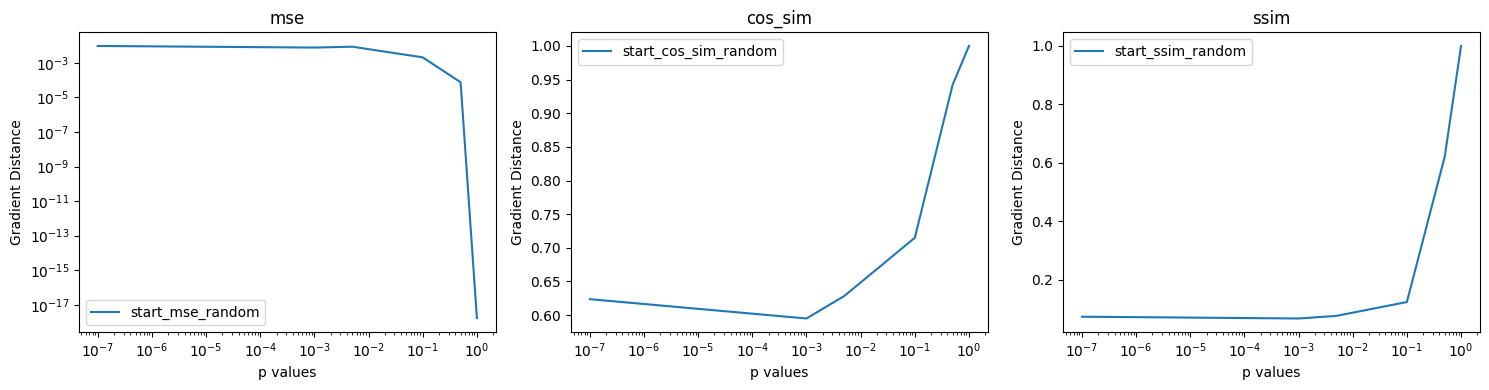

first ten of p_grad_actual_arr is: [-1.7788236e-07 -2.3286877e-06 -2.8319205e-06  2.4594283e-06
 -2.5908967e-06  0.0000000e+00 -3.0203350e-06  2.6574517e-06
 -2.8614966e-06 -5.2493397e-06]
first ten of p_grad_ideal_arr is: [ 6.5557067e-08  7.2027865e-07  8.6876332e-07 -8.6735480e-07
  8.1924748e-07  0.0000000e+00  8.9152377e-07 -9.3626875e-07
  8.9917143e-07  1.5725133e-06]
metric <function mse at 0x281255300> is: 1.5717593893072035e-11
first ten of p_grad_actual_arr is: [-2.4828525e-05 -2.8989110e-05 -1.0913911e-04  1.6281228e-04
 -2.9718387e-04  0.0000000e+00  1.2690388e-04 -1.1732675e-04
 -1.7381631e-04 -2.8529278e-06]
first ten of p_grad_ideal_arr is: [-3.4930967e-05  4.2255665e-06 -1.1279644e-06 -5.1125942e-05
  3.4999521e-05  0.0000000e+00 -3.7604845e-05  3.5372883e-05
  2.7847000e-05 -2.4583751e-05]
metric <function mse at 0x281255300> is: 2.6376548944995193e-08
first ten of p_grad_actual_arr is: [-6.8117035e-05 -5.0696141e-05  7.7751130e-05  4.1087087e-06
 -3.0101804e-05  0.000

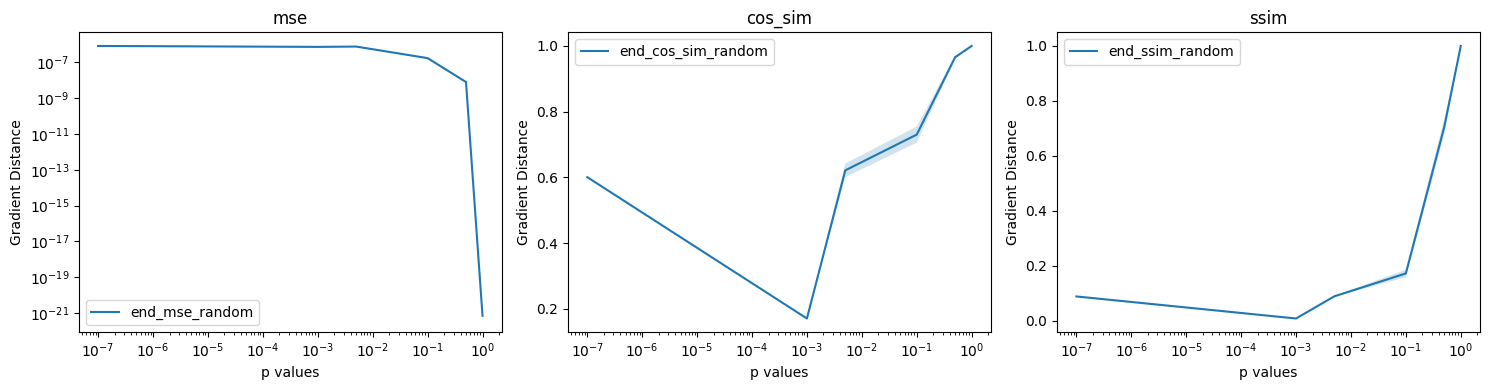

In [51]:
metrics_list = [mse, cos_sim, ssim]
# p_values = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 100, 1000]
# p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
p_values = [0.0000001, 0.001, 0.005, 0.1, 0.5, 1]
model_weight_types = ['bias']
model_layer_names = ['grad_layers.0']
dataset_name = 'MNIST_split'
fig_name_prefix = 'compare_start'
grad_loc_arr = ['start']
methods_arr = ['random']
num_runs = 3


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               grad_loc_arr = grad_loc_arr,
               methods_arr = methods_arr,
               plot_acc = False, 
               save_path = directory_path,
               fig_name_prefix = fig_name_prefix,
               num_runs = num_runs)

grad_loc_arr = ['end']
fig_name_prefix = 'compare_end'

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               grad_loc_arr = grad_loc_arr,
               methods_arr = methods_arr,
               plot_acc = False, 
               save_path = directory_path,
               fig_name_prefix = fig_name_prefix,
               num_runs = num_runs)

MNIST

using all good metrics

### LAMBDA

KeyboardInterrupt: 

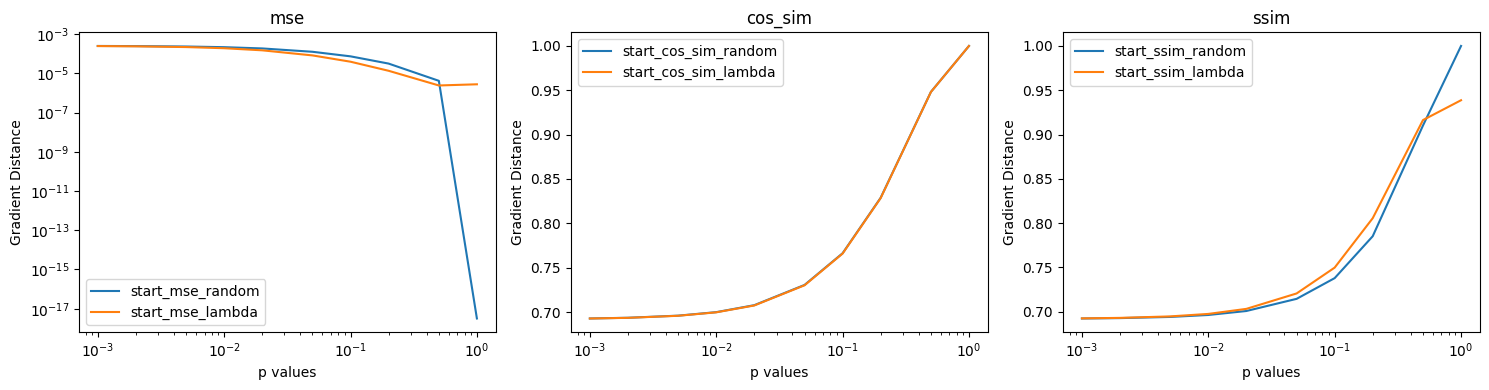

In [8]:
metrics_list = [mse, cos_sim, ssim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]#, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight']
model_layer_names = ['grad_layers.0']
dataset_name = 'MNIST_split'
fig_name_prefix = 'compare_start'
grad_loc_arr = ['start']
methods_arr = ['random', 'lambda']
num_runs = 2


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               grad_loc_arr = grad_loc_arr,
               methods_arr = methods_arr,
               plot_acc = False, 
               save_path = directory_path,
               fig_name_prefix = fig_name_prefix,
               num_runs = num_runs)

grad_loc_arr = ['end']
fig_name_prefix = 'compare_end'

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               grad_loc_arr = grad_loc_arr,
               methods_arr = methods_arr,
               plot_acc = False, 
               save_path = directory_path,
               fig_name_prefix = fig_name_prefix,
               num_runs = num_runs)

### GSS

p_std is: [2.24099495e-09 5.02550392e-09 2.75322236e-09 6.66659616e-10
 2.79578671e-09 1.35056325e-08 3.19450919e-09 2.12166924e-09
 9.71795089e-11]
p_std is: [1.78697519e-09 1.99579517e-09 2.26027623e-09 3.11811164e-09
 1.05246727e-08 3.33602657e-09 8.19454726e-10 1.13332135e-09
 3.80020992e-10]
p_std is: [1.16229057e-06 3.02791595e-06 6.69956207e-06 3.14116478e-06
 5.93662262e-06 1.17719173e-05 1.43229961e-05 1.73449516e-06
 3.57031822e-06]
p_std is: [1.40070915e-06 1.47223473e-06 3.30805779e-06 3.53455544e-06
 3.01837921e-05 6.71982765e-05 3.60071659e-05 6.30021095e-06
 8.22544098e-07]
p_std is: [1.65498583e-07 4.37613574e-07 2.84501845e-06 4.70645319e-07
 1.72373344e-06 2.26749709e-06 3.52675168e-06 2.37601705e-06
 1.10926144e-06]
p_std is: [3.81096257e-07 9.17320263e-07 2.64218293e-06 4.10050572e-06
 1.84860610e-05 3.17518954e-05 2.30577842e-05 1.10724119e-05
 9.67587975e-06]


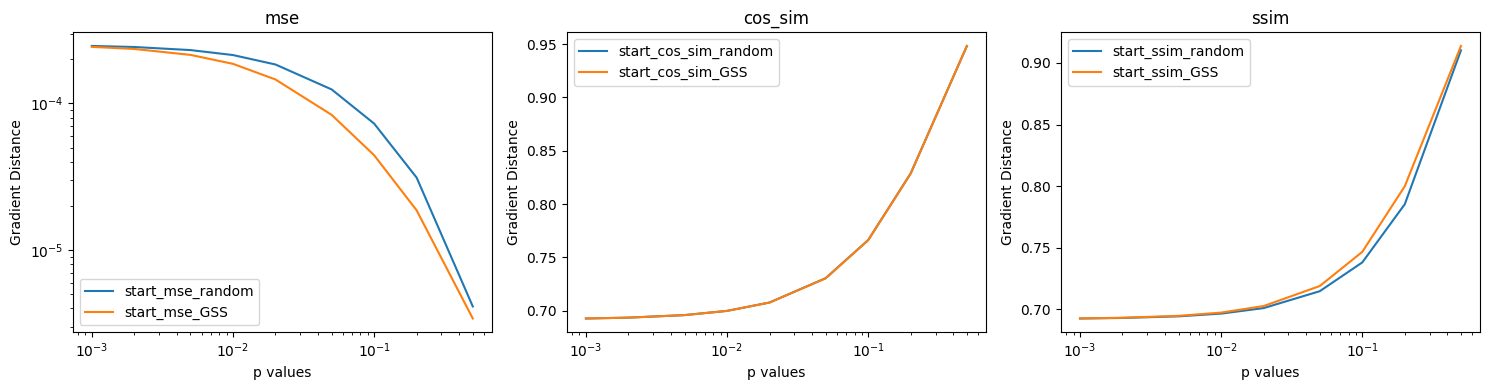

In [ ]:
metrics_list = [mse, cos_sim, ssim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]#, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight']
model_layer_names = ['grad_layers.0']
dataset_name = 'MNIST_split'
fig_name_prefix = 'compare_start'
grad_loc_arr = ['start']
methods_arr = ['random', 'GSS']
num_runs = 2


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               grad_loc_arr = grad_loc_arr,
               methods_arr = methods_arr,
               plot_acc = False, 
               save_path = directory_path,
               fig_name_prefix = fig_name_prefix,
               num_runs = num_runs)

In [ ]:
metrics_list = [mse, cos_sim, ssim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]#, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight']
model_layer_names = ['grad_layers.0']
dataset_name = 'MNIST_split'
fig_name_prefix = 'compare_end'
grad_loc_arr = ['end']
methods_arr = ['random', 'GSS']
num_runs = 2


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               grad_loc_arr = grad_loc_arr,
               methods_arr = methods_arr,
               plot_acc = False, 
               save_path = directory_path,
               fig_name_prefix = fig_name_prefix,
               num_runs = num_runs)

p_std is: [5.55373813e-13 5.78066901e-12 1.10153518e-12 1.68928215e-11
 3.68497573e-11 3.52377785e-11 1.16243028e-11 2.70575463e-12
 2.85760619e-13]
p_std is: [8.84004675e-13 3.83248641e-12 1.54570676e-11 2.71306750e-11
 3.96470650e-12 5.10975776e-12 1.95179728e-11 3.54723882e-12
 1.61703205e-12]
p_std is: [7.84592144e-04 4.75500515e-03 3.65784392e-05 3.32617536e-03
 8.41695676e-04 3.13623995e-03 3.13522629e-02 3.11604381e-02
 9.59175229e-03]
p_std is: [0.00098466 0.00392016 0.00400869 0.00217418 0.01067212 0.01479796
 0.00801079 0.00296085 0.01076669]
p_std is: [0.00012702 0.00026138 0.00027849 0.00043922 0.00069563 0.0006828
 0.00311749 0.00529572 0.00141561]
p_std is: [0.00026236 0.00050336 0.00025773 0.00051344 0.00103506 0.00091462
 0.0005426  0.00119392 0.00514014]


KeyboardInterrupt: 

p_grad_actual_arr is: -2.101069318527493e-09
p_grad_ideal_arr is: -4.130204622754263e-09
p_grad_actual_arr is: -1.8434000992328947e-08
p_grad_ideal_arr is: -6.927388085387065e-08
p_grad_actual_arr is: 1.5203840963984305e-10
p_grad_ideal_arr is: 3.403110848676505e-10
p_grad_actual_arr is: 1.3988028790823392e-10
p_grad_ideal_arr is: 3.8698999560438097e-10
p_grad_actual_arr is: -1.0817993825185113e-06
p_grad_ideal_arr is: -1.3266871690120752e-07
p_grad_actual_arr is: -1.0500623830012046e-05
p_grad_ideal_arr is: -1.516223392172833e-06
p_grad_actual_arr is: 3.939494563898194e-10
p_grad_ideal_arr is: 1.881271666226425e-10
p_grad_actual_arr is: 4.94765117764473e-10
p_grad_ideal_arr is: 4.6129572384145945e-10
p_grad_actual_arr is: -2.637559930462885e-07
p_grad_ideal_arr is: -4.991886015659475e-09
p_grad_actual_arr is: -2.8959320843569003e-06
p_grad_ideal_arr is: -7.53298010636172e-08
p_grad_actual_arr is: 8.903443537988665e-10
p_grad_ideal_arr is: 5.778856837501678e-10
p_grad_actual_arr is: 6.

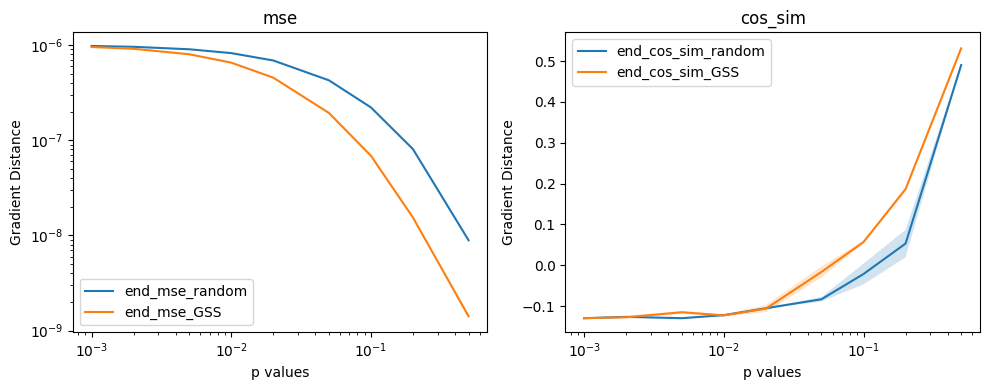

In [ ]:
metrics_list = [mse, cos_sim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_layers.0', 'grad_output_layer']
dataset_name = 'MNIST_split'
fig_name_prefix = 'all_compare_end'
grad_loc_arr = ['end']
methods_arr = ['random', 'GSS']
num_runs = 2


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               grad_loc_arr = grad_loc_arr,
               methods_arr = methods_arr,
               plot_acc = False, 
               save_path = directory_path,
               fig_name_prefix = fig_name_prefix,
               num_runs = num_runs)

p_grad_actual_arr is: -0.00018461415311321616
p_grad_ideal_arr is: -3.906055280822329e-05
p_grad_actual_arr is: -0.0010758830467239022
p_grad_ideal_arr is: 8.952179632615298e-05
p_grad_actual_arr is: 0.0
p_grad_ideal_arr is: -5.960464760645934e-11
p_grad_actual_arr is: 0.0
p_grad_ideal_arr is: 3.7252903539730653e-10
p_grad_actual_arr is: 0.0020687435753643513
p_grad_ideal_arr is: 0.00044732075184583664
p_grad_actual_arr is: 0.014179866760969162
p_grad_ideal_arr is: 0.0029826306272298098
p_grad_actual_arr is: -3.093719442404108e-06
p_grad_ideal_arr is: -6.942748882465821e-07
p_grad_actual_arr is: -5.9604645663569045e-09
p_grad_ideal_arr is: -2.9802322831784522e-09
p_grad_actual_arr is: 0.0010915554594248533
p_grad_ideal_arr is: 0.0005145824979990721
p_grad_actual_arr is: 0.007909495383501053
p_grad_ideal_arr is: 0.00384942046366632
p_grad_actual_arr is: -8.754730060900329e-07
p_grad_ideal_arr is: -6.790161251046811e-07
p_grad_actual_arr is: 1.1920929132713809e-08
p_grad_ideal_arr is: 0.

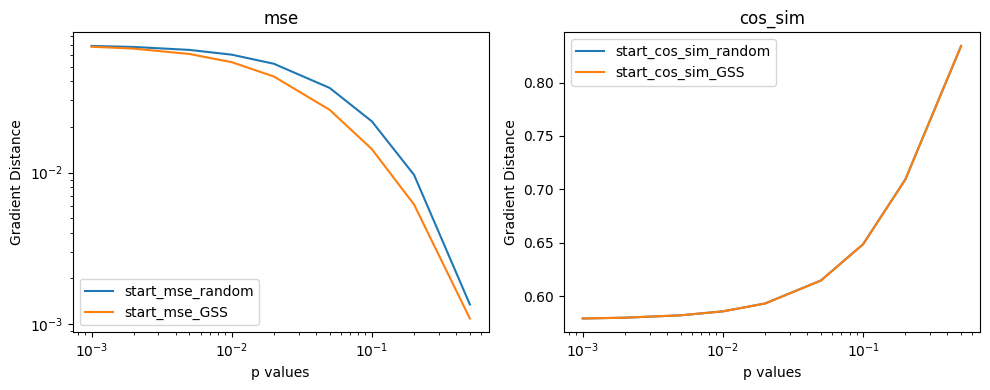

In [ ]:
metrics_list = [mse, cos_sim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_layers.0', 'grad_output_layer']
dataset_name = 'MNIST_split'
fig_name_prefix = 'all_compare_start'
grad_loc_arr = ['start']
methods_arr = ['random', 'GSS']
num_runs = 2


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               grad_loc_arr = grad_loc_arr,
               methods_arr = methods_arr,
               plot_acc = False, 
               save_path = directory_path,
               fig_name_prefix = fig_name_prefix,
               num_runs = num_runs)

CIFAR

all good metrics

In [ ]:
metrics_list = [mse, cos_sim, ssim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight']
model_layer_names = ['grad_conv_block.0', 'grad_conv_block.2', 'grad_conv_block.6', 'grad_conv_block.8']
dataset_name = 'cifar10_split'
fig_name_prefix = 'all_metrics'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

TypeError: plot_grad_dist() missing 2 required positional arguments: 'grad_loc_arr' and 'methods_arr'

MNIST

good metrics, no ssim, so done on all layers

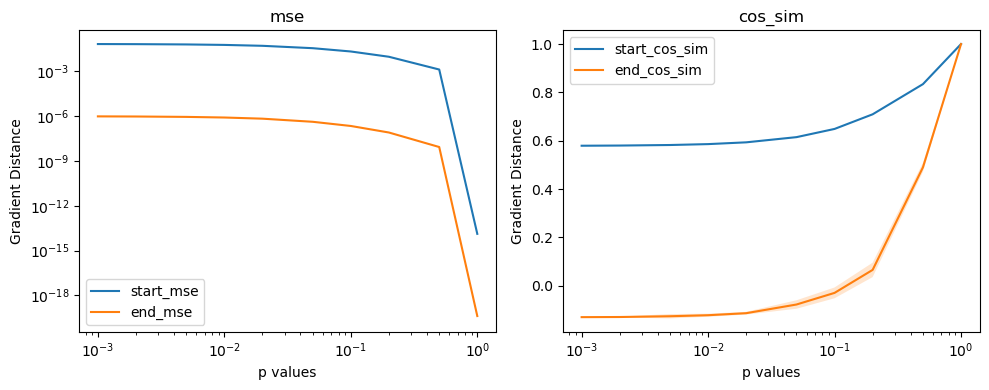

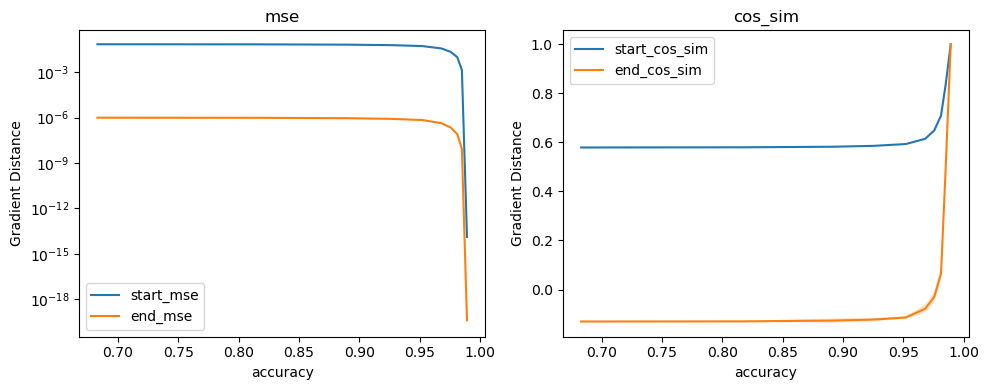

In [ ]:
metrics_list = [mse, cos_sim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_layers.0', 'grad_output_layer']
dataset_name = 'MNIST_split'
fig_name_prefix = 'all_layers'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

CIFAR

good metrics, all layers

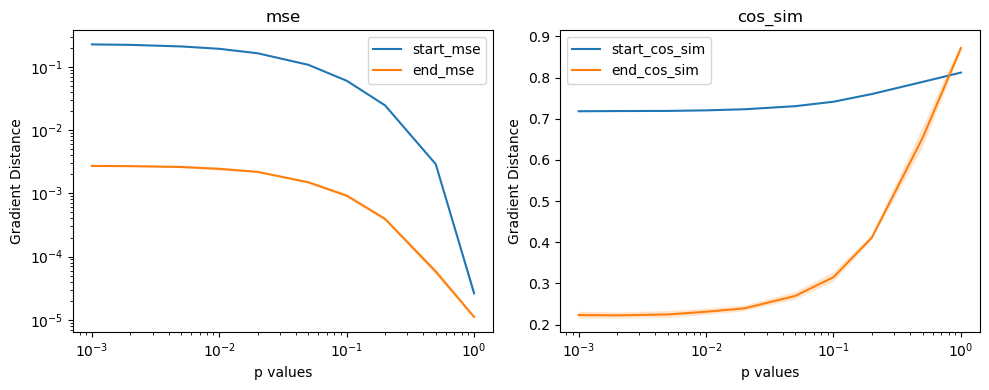

In [ ]:
metrics_list = [mse, cos_sim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_conv_block.0', 'grad_conv_block.2', 'grad_conv_block.6', 'grad_conv_block.8',
                     'grad_linear_block.0', 'grad_out_block']
dataset_name = 'cifar10_split'
fig_name_prefix = 'all_layers'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

MNIST bad metrics

We will do this on all layers

In [ ]:
metrics_list = [inf_norm]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_layers.0', 'grad_output_layer']
dataset_name = 'MNIST_split'
fig_name_prefix = 'bad_metrics'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)

CIFAR

bad metrics on all layers

In [ ]:
metrics_list = [inf_norm]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
model_weight_types = ['weight', 'bias']
model_layer_names = ['grad_conv_block.0', 'grad_conv_block.2', 'grad_conv_block.6', 'grad_conv_block.8',
                     'grad_linear_block.0', 'grad_out_block']
dataset_name = 'cifar10_split'
fig_name_prefix = 'bad_metrics'


plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = False, 
               fig_name_prefix = fig_name_prefix)

plot_grad_dist(metrics = metrics_list, 
               p_vals = p_values, 
               get_grad_dist_func = get_grad_dist, 
               model_weight_types = model_weight_types, 
               model_layer_names = model_layer_names, 
               dataset_name = dataset_name, 
               plot_acc = True, 
               fig_name_prefix = fig_name_prefix)